# Mines and Rocks Classification
>> 数据为使用声呐采集岩石、矿山的数据，通过声呐的返回的信息判断吴志是金属还是岩石。数据集中有208条数据记录，每条记录记录了60种不同唢呐探测到的数据和实际的分类结果。


In [65]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression  # 逻辑回归是一个二分类模型
from sklearn.neighbors import KNeighborsClassifier  # K近邻分类器
from sklearn.svm import SVC  # 支持向量机
from sklearn.tree import DecisionTreeClassifier  # 决策树分类器
from sklearn.naive_bayes import GaussianNB  # 高斯朴素贝叶斯分类器

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 设置不输出warning告警
import warnings

warnings.filterwarnings("ignore")


In [2]:
# 读取数据
sonar_data = pd.read_csv('data/sonar_data.csv', header=None)
print("data size:", sonar_data.shape)
print("data describe:\n", sonar_data.describe())
sonar_data.head(10)

data size: (208, 61)
data describe:
                0           1           2           3           4           5   \
count  208.000000  208.000000  208.000000  208.000000  208.000000  208.000000   
mean     0.029164    0.038437    0.043832    0.053892    0.075202    0.104570   
std      0.022991    0.032960    0.038428    0.046528    0.055552    0.059105   
min      0.001500    0.000600    0.001500    0.005800    0.006700    0.010200   
25%      0.013350    0.016450    0.018950    0.024375    0.038050    0.067025   
50%      0.022800    0.030800    0.034300    0.044050    0.062500    0.092150   
75%      0.035550    0.047950    0.057950    0.064500    0.100275    0.134125   
max      0.137100    0.233900    0.305900    0.426400    0.401000    0.382300   

               6           7           8           9   ...          50  \
count  208.000000  208.000000  208.000000  208.000000  ...  208.000000   
mean     0.121747    0.134799    0.178003    0.208259  ...    0.016069   
std      0.

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R
5,0.0286,0.0453,0.0277,0.0174,0.0384,0.0990,0.1201,0.1833,0.2105,0.3039,...,0.0045,0.0014,0.0038,0.0013,0.0089,0.0057,0.0027,0.0051,0.0062,R
6,0.0317,0.0956,0.1321,0.1408,0.1674,0.1710,0.0731,0.1401,0.2083,0.3513,...,0.0201,0.0248,0.0131,0.0070,0.0138,0.0092,0.0143,0.0036,0.0103,R
7,0.0519,0.0548,0.0842,0.0319,0.1158,0.0922,0.1027,0.0613,0.1465,0.2838,...,0.0081,0.0120,0.0045,0.0121,0.0097,0.0085,0.0047,0.0048,0.0053,R
8,0.0223,0.0375,0.0484,0.0475,0.0647,0.0591,0.0753,0.0098,0.0684,0.1487,...,0.0145,0.0128,0.0145,0.0058,0.0049,0.0065,0.0093,0.0059,0.0022,R
9,0.0164,0.0173,0.0347,0.0070,0.0187,0.0671,0.1056,0.0697,0.0962,0.0251,...,0.0090,0.0223,0.0179,0.0084,0.0068,0.0032,0.0035,0.0056,0.0040,R


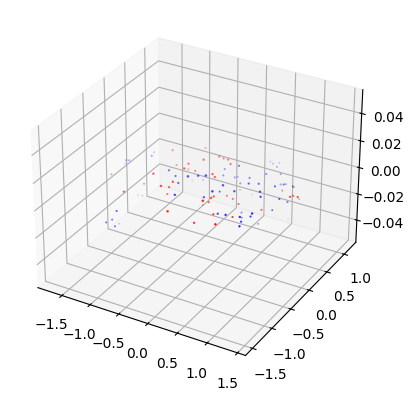

In [7]:
# 分别绘制两种类型数据的散点图-使用pca降维： 散点图看数据并没有明确的分界
# %matplotlib inline  
# %matplotlib notebook
# %pylab

from sklearn.decomposition import PCA

pca = PCA(n_components=3)
sonar_data_3d = pca.fit_transform(sonar_data.iloc[:, :-1])
target = sonar_data.iloc[:, -1]
target_name = ['R', 'M']
target_color = ["red", "blue"]
plt.axes(projection='3d')
for name, color in zip(target_name, target_color):
    plt.scatter(sonar_data_3d[target == name, 0],
                sonar_data_3d[target == name, 1],
                sonar_data_3d[target == name, 2],
                c=color, label=name)
plt.show()

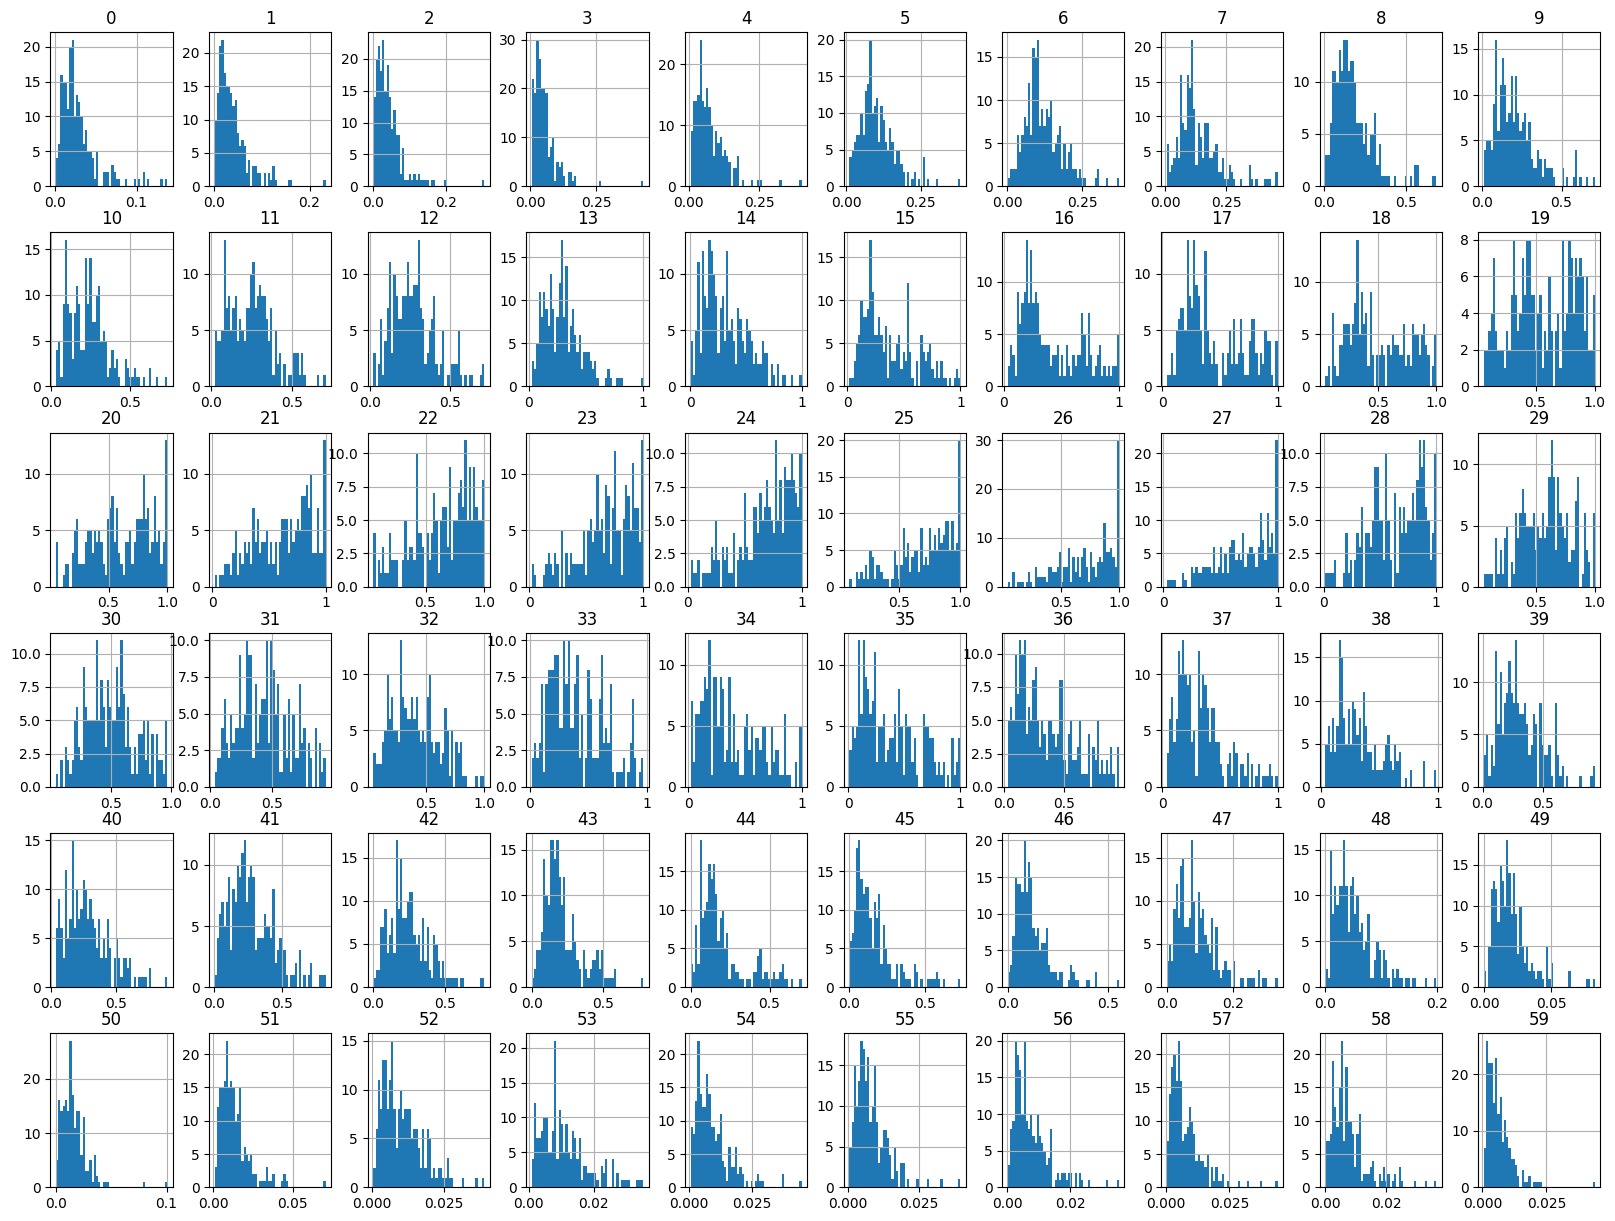

In [14]:
sonar_data.hist(figsize=(20, 15), bins=50, layout=(6, 10))
plt.show()

In [30]:
# 分离训练数据和测试数据
X = sonar_data.iloc[:, :-1].values
Y = sonar_data.iloc[:, -1].values
vaild_size = 0.2
seed = 7
X_train, X_vaild, Y_train, Y_vaild = train_test_split(X, Y, test_size=vaild_size, random_state=seed)

LR: 0.7717 (0.0910)
KNN: 0.7588 (0.1064)
SVM: 0.7651 (0.0875)
DT: 0.7816 (0.0954)
NB: 0.6827 (0.1360)
XGB: 0.7967 (0.1044)
LGBM: 0.8316 (0.0947)


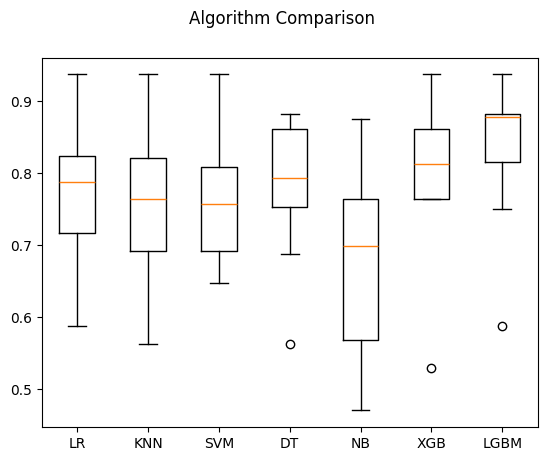

In [35]:
num_folds = 10
scoring = "accuracy"

models = {}
models['LR'] = LogisticRegression()
models['KNN'] = KNeighborsClassifier()
models['SVM'] = SVC()
models['DT'] = DecisionTreeClassifier()
models['NB'] = GaussianNB()
models['XGB'] = XGBClassifier(use_label_encoder=False,
                              eval_metric='logloss')  # use_label_encoder=False to avoid warning
models['LGBM'] = LGBMClassifier(**{"verbose": -1})

results = {}
for name, model in models.items():
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    Y_train_tmp = Y_train.copy()
    # XGB需要将标签转为0和1
    if name == 'XGB':
        Y_train_tmp = np.where(Y_train_tmp == 'M', 1, 0)
    cv_results = cross_val_score(model, X_train, Y_train_tmp, cv=kfold, scoring=scoring)
    results[name] = cv_results
    print(f"{name}: {cv_results.mean():.4f} ({cv_results.std():.4f})")

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results.values())
ax.set_xticklabels(results.keys())
plt.show()
## 

LR: 0.7544 (0.0679)
KNN: 0.8085 (0.1080)
SVM: 0.8261 (0.0818)
DT: 0.7456 (0.0758)
NB: 0.6827 (0.1360)
XGB: 0.7967 (0.1044)
LGBM: 0.8320 (0.0947)


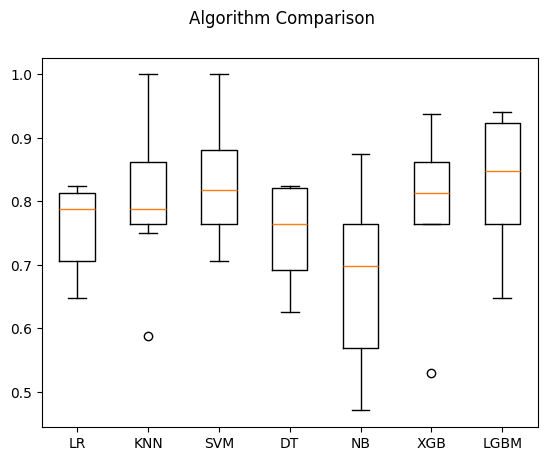

In [42]:
pipelines = {}
pipelines['LR'] = Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression())])
pipelines['KNN'] = Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsClassifier())])
pipelines['SVM'] = Pipeline([('Scaler', StandardScaler()), ('SVM', SVC())])
pipelines['DT'] = Pipeline([('Scaler', StandardScaler()), ('DT', DecisionTreeClassifier())])
pipelines['NB'] = Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())])
pipelines['XGB'] = Pipeline(
    [('Scaler', StandardScaler()), ('XGB', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))])
pipelines['LGBM'] = Pipeline([('Scaler', StandardScaler()), ('LGBM', LGBMClassifier(**{"verbose": -1}))])

pip_results = {}
for name, model in pipelines.items():
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    Y_train_tmp = Y_train.copy()
    # XGB需要将标签转为0和1
    if name == 'XGB':
        Y_train_tmp = np.where(Y_train_tmp == 'M', 1, 0)
    cv_results = cross_val_score(model, X_train, Y_train_tmp, cv=kfold, scoring=scoring)
    pip_results[name] = cv_results
    print(f"{name}: {cv_results.mean():.4f} ({cv_results.std():.4f})")

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(pip_results.values())
ax.set_xticklabels(pip_results.keys())
plt.show()
# 数据正则化后KNN和支持向量机效果的一定提升。

In [48]:
# 网格搜索调参- knn
scaler = StandardScaler().fit(X_train)
scaler_data = scaler.transform(X_train)
param_grid = {'n_neighbors': np.arange(1, 21, 2)}
knn = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
knn_grid = GridSearchCV(knn, param_grid, cv=kfold, scoring=scoring)
knn_grid_res = knn_grid.fit(scaler_data, Y_train)
print("knn Best parameters:", knn_grid_res.best_params_)
print("knn Best score:", knn_grid_res.best_score_)

knn_cv_results = zip(knn_grid_res.cv_results_['mean_test_score'],
                     knn_grid_res.cv_results_['std_test_score'],
                     knn_grid_res.cv_results_['params'])
for mean, std, params in cv_results:
    print(f"avg_auc:{mean:.3f} (auc_std:+/-{std * 2:.03f}) ,param: {params}")


Best parameters: {'n_neighbors': 1}
Best score: 0.8360294117647058
avg_auc:0.836 (auc_std:+/-0.159) ,param: {'n_neighbors': 1}
avg_auc:0.814 (auc_std:+/-0.176) ,param: {'n_neighbors': 3}
avg_auc:0.814 (auc_std:+/-0.194) ,param: {'n_neighbors': 5}
avg_auc:0.778 (auc_std:+/-0.241) ,param: {'n_neighbors': 7}
avg_auc:0.730 (auc_std:+/-0.199) ,param: {'n_neighbors': 9}
avg_auc:0.742 (auc_std:+/-0.148) ,param: {'n_neighbors': 11}
avg_auc:0.711 (auc_std:+/-0.212) ,param: {'n_neighbors': 13}
avg_auc:0.723 (auc_std:+/-0.162) ,param: {'n_neighbors': 15}
avg_auc:0.699 (auc_std:+/-0.145) ,param: {'n_neighbors': 17}
avg_auc:0.711 (auc_std:+/-0.183) ,param: {'n_neighbors': 19}


In [67]:
# 使用模型进行效果评估-knn
knn_best = KNeighborsClassifier(n_neighbors=1)
knn_best.fit(scaler_data, Y_train)

scaler_x_vaild = scaler.transform(X_vaild)
predictions = knn_best.predict(scaler_x_vaild)
print("knn accuracy:", accuracy_score(Y_vaild, predictions))
print("knn confusion matrix:\n",
      pd.DataFrame(confusion_matrix(Y_vaild, predictions), columns=np.unique(Y_vaild), index=np.unique(Y_vaild)))
print("knn classification report:\n", classification_report(Y_vaild, predictions, target_names=target_name))


knn accuracy: 0.8095238095238095
knn confusion matrix:
     M   R
M  21   6
R   2  13
knn classification report:
               precision    recall  f1-score   support

           R       0.91      0.78      0.84        27
           M       0.68      0.87      0.76        15

    accuracy                           0.81        42
   macro avg       0.80      0.82      0.80        42
weighted avg       0.83      0.81      0.81        42


In [60]:
# 网格搜索调参- svm

param_grid = {
    'C': [0.01, 0.1, 0.3, 0.7, 1, 2, 3],
    'kernel': ['linear', 'rbf', 'poly']
}
svm = SVC()
svm_grid = GridSearchCV(svm, param_grid, cv=kfold, scoring=scoring)
svm_grid_res = svm_grid.fit(scaler_data, Y_train)
print("svm Best parameters:", svm_grid_res.best_params_)
print("svm Best score:", svm_grid_res.best_score_)

svm_cv_results = zip(svm_grid_res.cv_results_['mean_test_score'],
                     svm_grid_res.cv_results_['std_test_score'],
                     svm_grid_res.cv_results_['params'])
for mean, std, params in svm_cv_results:
    print(f"avg_auc:{mean:.3f} (auc_std:+/-{std * 2:.03f}) ,param: {params}")


svm Best parameters: {'C': 3, 'kernel': 'poly'}
svm Best score: 0.85625
avg_auc:0.809 (auc_std:+/-0.152) ,param: {'C': 0.01, 'kernel': 'linear'}
avg_auc:0.458 (auc_std:+/-0.341) ,param: {'C': 0.01, 'kernel': 'rbf'}
avg_auc:0.415 (auc_std:+/-0.198) ,param: {'C': 0.01, 'kernel': 'poly'}
avg_auc:0.749 (auc_std:+/-0.140) ,param: {'C': 0.1, 'kernel': 'linear'}
avg_auc:0.601 (auc_std:+/-0.369) ,param: {'C': 0.1, 'kernel': 'rbf'}
avg_auc:0.583 (auc_std:+/-0.254) ,param: {'C': 0.1, 'kernel': 'poly'}
avg_auc:0.754 (auc_std:+/-0.165) ,param: {'C': 0.3, 'kernel': 'linear'}
avg_auc:0.742 (auc_std:+/-0.164) ,param: {'C': 0.3, 'kernel': 'rbf'}
avg_auc:0.644 (auc_std:+/-0.200) ,param: {'C': 0.3, 'kernel': 'poly'}
avg_auc:0.760 (auc_std:+/-0.166) ,param: {'C': 0.7, 'kernel': 'linear'}
avg_auc:0.814 (auc_std:+/-0.120) ,param: {'C': 0.7, 'kernel': 'rbf'}
avg_auc:0.760 (auc_std:+/-0.188) ,param: {'C': 0.7, 'kernel': 'poly'}
avg_auc:0.772 (auc_std:+/-0.124) ,param: {'C': 1, 'kernel': 'linear'}
avg_auc:0.8

In [68]:
# 使用模型进行效果评估-svm
svm_best = SVC(C=3, kernel='poly')
svm_best.fit(scaler_data, Y_train)
scaler_x_vaild = scaler.transform(X_vaild)
predictions = svm_best.predict(scaler_x_vaild)
print("svm accuracy:", accuracy_score(Y_vaild, predictions))
print("svm confusion matrix:\n",
      pd.DataFrame(confusion_matrix(Y_vaild, predictions), columns=np.unique(Y_vaild), index=np.unique(Y_vaild)))
print("svm classification report:\n", classification_report(Y_vaild, predictions, target_names=target_name))

svm accuracy: 0.8333333333333334
svm confusion matrix:
     M   R
M  23   4
R   3  12
svm classification report:
               precision    recall  f1-score   support

           R       0.88      0.85      0.87        27
           M       0.75      0.80      0.77        15

    accuracy                           0.83        42
   macro avg       0.82      0.83      0.82        42
weighted avg       0.84      0.83      0.83        42


In [62]:
# 网格搜索调参- xgboost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_grid = GridSearchCV(xgb, param_grid, cv=kfold, scoring=scoring)
Y_train_tmp = np.where(Y_train == 'M', 1, 0)
xgb_grid_res = xgb_grid.fit(scaler_data, Y_train_tmp)
print("xgb Best parameters:", xgb_grid_res.best_params_)
print("xgb Best score:", xgb_grid_res.best_score_)
xgb_cv_results = zip(xgb_grid_res.cv_results_['mean_test_score'],
                     xgb_grid_res.cv_results_['std_test_score'],
                     xgb_grid_res.cv_results_['params'])
for mean, std, params in xgb_cv_results:
    print(f"avg_auc:{mean:.3f} (auc_std:+/-{std * 2:.03f}) ,param: {params}")

xgb Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6}
xgb Best score: 0.8691176470588236
avg_auc:0.743 (auc_std:+/-0.220) ,param: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.6}
avg_auc:0.706 (auc_std:+/-0.235) ,param: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
avg_auc:0.676 (auc_std:+/-0.173) ,param: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
avg_auc:0.761 (auc_std:+/-0.251) ,param: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}
avg_auc:0.730 (auc_std:+/-0.247) ,param: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
avg_auc:0.705 (auc_std:+/-0.205) ,param: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
avg_auc:0.785 (auc_std:+/-0.210) ,param: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6}
avg_auc:0.772 (auc_std:+/-0.2

In [72]:
# 使用模型进行效果评估-xgboost

xgb_best = XGBClassifier(**{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6},
                         use_label_encoder=False, eval_metric='logloss')
Y_train_tmp = np.where(Y_train == 'M', 1, 0)
xgb_best.fit(scaler_data, Y_train_tmp)
scaler_x_vaild = scaler.transform(X_vaild)
predictions = xgb_best.predict(scaler_x_vaild)
Y_vaild_tmp= np.where(Y_vaild == 'M', 1, 0) 
print("xgb accuracy:", accuracy_score(Y_vaild_tmp, predictions))
print("xgb confusion matrix:\n",
      pd.DataFrame(confusion_matrix(Y_vaild_tmp, predictions), columns=np.unique(Y_vaild_tmp), index=np.unique(Y_vaild_tmp)))
print("xgb classification report:\n", classification_report(Y_vaild_tmp, predictions, target_names=target_name))

xgb accuracy: 0.9047619047619048
xgb confusion matrix:
     0   1
0  13   2
1   2  25
xgb classification report:
               precision    recall  f1-score   support

           R       0.87      0.87      0.87        15
           M       0.93      0.93      0.93        27

    accuracy                           0.90        42
   macro avg       0.90      0.90      0.90        42
weighted avg       0.90      0.90      0.90        42


In [63]:
# 网格搜索调参- lgbm
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 63, 127]
}
lgbm = LGBMClassifier(**{"verbose": -1})
lgbm_grid = GridSearchCV(lgbm, param_grid, cv=kfold, scoring=scoring)
lgbm_grid_res = lgbm_grid.fit(scaler_data, Y_train)
print("lgbm Best parameters:", lgbm_grid_res.best_params_)
print("lgbm Best score:", lgbm_grid_res.best_score_)
lgbm_cv_results = zip(lgbm_grid_res.cv_results_['mean_test_score'],
                      lgbm_grid_res.cv_results_['std_test_score'],
                      lgbm_grid_res.cv_results_['params'])
for mean, std, params in lgbm_cv_results:
    print(f"avg_auc:{mean:.3f} (auc_std:+/-{std * 2:.03f}) ,param: {params}")

lgbm Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'num_leaves': 31}
lgbm Best score: 0.8610294117647058
avg_auc:0.687 (auc_std:+/-0.127) ,param: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'num_leaves': 31}
avg_auc:0.687 (auc_std:+/-0.127) ,param: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'num_leaves': 63}
avg_auc:0.687 (auc_std:+/-0.127) ,param: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'num_leaves': 127}
avg_auc:0.712 (auc_std:+/-0.258) ,param: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
avg_auc:0.712 (auc_std:+/-0.258) ,param: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 63}
avg_auc:0.712 (auc_std:+/-0.258) ,param: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 127}
avg_auc:0.772 (auc_std:+/-0.227) ,param: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'num_leaves': 31}
avg_auc:0.772 (auc_std:+/

In [73]:
# 使用模型进行效果评估-lgbm
lgbm_best = LGBMClassifier(**{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'num_leaves': 31},
                           **{"verbose": -1})
lgbm_best.fit(scaler_data, Y_train)
scaler_x_vaild = scaler.transform(X_vaild)
predictions = lgbm_best.predict(scaler_x_vaild)
print("lgbm accuracy:", accuracy_score(Y_vaild, predictions))
print("lgbm confusion matrix:\n",
      pd.DataFrame(confusion_matrix(Y_vaild, predictions), columns=np.unique(Y_vaild), index=np.unique(Y_vaild)))
print("lgbm classification report:\n", classification_report(Y_vaild, predictions, target_names=target_name))
# 分类效果最好的模型是xgboost和lgbm，准确率都在90%以上。

lgbm accuracy: 0.9285714285714286
lgbm confusion matrix:
     M   R
M  25   2
R   1  14
lgbm classification report:
               precision    recall  f1-score   support

           R       0.96      0.93      0.94        27
           M       0.88      0.93      0.90        15

    accuracy                           0.93        42
   macro avg       0.92      0.93      0.92        42
weighted avg       0.93      0.93      0.93        42
